In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from abc import ABCMeta, abstractmethod

# Preprocess

In [6]:
class Prepare:
    def __init__(self, train, test, scaler):
        self.train = train
        self.test = test
        self.scaler = scaler

    def preprocess(self):
        encoder = LabelEncoder()
        cat_features = 'Sex'
        target = 'Rings'
        self.train.drop(columns=['id'], axis=1, inplace=True)
        self.ids = self.test['id']  
        self.test.drop(columns=['id'], axis=1, inplace=True)
        continuous_features = [col for col in self.train.columns if col not in [cat_features, target]]
        self.train[cat_features] = encoder.fit_transform(self.train[cat_features])
        self.test[cat_features] = encoder.fit_transform(self.test[cat_features])
        self.train[continuous_features] = self.scaler.fit_transform(self.train[continuous_features])
        self.test[continuous_features] = self.scaler.transform(self.test[continuous_features])

        X = self.train.drop(columns=[target], axis=1)
        y = self.train[target]
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=24)
        return X_train, X_val, y_train, y_val

# MLP from scratch

In [7]:
class loss(metaclass=ABCMeta):
    '''
    The abstract base class for loss function.
    For each loss, the gradient should be specified.
    '''
    def obj(self,pred,true):
        pass
    
    def gradient(self,pred,true):
        pass
        
class mse(loss):
    '''Loss function for mse.'''
    def obj(self,pred,true):
        return np.square(pred-true).mean()/2
    
    def gradient(self,pred,true):
        return pred-true
    
class log_loss(loss):
    '''Loss fucntion for log loss.'''
    def obj(self,pred,true):
        return (-np.multiply(true,np.log(pred))-np.multiply(1-y,np.log(1-pred))).mean()
    
    def gradient(self,pred,true):
        return -np.multiply(true,1/pred)+np.multiply(1-true,1/(1-pred))


class act(metaclass=ABCMeta):
    '''
    The abstract base class for activation function.
    For each loss, 
    the functions used for forward and backward propagation are specified respectively.
    The two functions take same inputs.
    The forward function would return the values after the transformation.
    The backward function would return the derivative musk at this layer.
    '''
    def forward(self,matrix):
        pass
    
    def backward(self,matrix):
        pass
        
class linear(act):
    '''Linear activation function.'''
    def forward(self,matrix):
        return matrix
    
    def backward(self,matrix):
        return np.ones_like(matrix)
    
class relu(act):
    '''Rectified linear units.'''
    def forward(self,matrix):
        return np.multiply(matrix>0,matrix)
    
    def backward(self,matrix):
        return 1*(matrix>0)
        
class logistic(act):
    '''Logistic transformation'''
    def forward(self,matrix):
        return 1/(1+np.exp(-matrix)+0.000001)
    
    def backward(self,matrix):
        return np.multiply(self.forward(matrix),1-self.forward(matrix))


class MLP(object):
    '''
    Parameters:
    ----------
    n_hidden_units: Number of units in the hidden layer.
    batch_size: Number of data points used in each gradient step.
    n_epochs: Number of epochs.
              Note that this determines the number of epochs (how many times each data point will be used),
              not the number of gradient steps.
    learning_rate: The learning rate of gradient descent.
    momentum: Momentum for gradient descent update. (Between 0 and 1.)
    weight_decay: Coeffecients for L2 regularization. (Also known as weight decay.)
    activation: Activation function for the hidden layer.
                'relu' for rectified linear units.
                'logistic' for sigmoid activation.
                'linear' for linear activation
    loss: Loss function.
          'mse' for regression task
          'log_loss' for classfication task.
    '''
        
    def __init__(self,
                 n_hidden_units=100,
                 batch_size=200,
                 n_epochs=200,
                 learning_rate=0.01,
                 momentum=0.9,
                 weight_decay=0.0001,
                 activation='relu',
                 loss='mse'):

        self.n_hidden_units=n_hidden_units
        self.batch_size=batch_size
        self.n_epochs=n_epochs
        self.learning_rate=learning_rate
        self.momentum=momentum
        self.weight_decay=weight_decay
        self.train_loss_history = []
        self.validation_loss_history = []

        #activation (This is the activation function for the hidden layer.)
        if activation=='relu':
            self.act1=relu()
        elif activation=='logistic':
            self.act1=logistic()
        elif activation=='linear':
            self.act1=linear()
        else:
            self.act1=activation

        #loss (Note that the activation function for the output layer is determined by the loss.)
        if loss=='mse':
            self.loss=mse()
            self.act2=linear()
        elif loss=='log_loss':
            self.loss=log_loss()
            self.act2=logistic()
        else:
            self.loss=loss[0]
            self.act2=loss[1]

    def forward(self):
        self.layer1=self.W1*self.X+self.b1
        self.layer1act=self.act1.forward(self.layer1)
        self.score=self.W2*self.layer1act+self.b2
        self.pred=self.act2.forward(self.score)

    def backward(self):
        self.dpred=self.loss.gradient(self.pred,self.true)
        self.dscore=np.multiply(self.dpred,self.act2.backward(self.score))
        self.dlayer1act=self.W2.T*self.dscore
        self.dlayer1=np.multiply(self.dlayer1act,self.act1.backward(self.layer1))
        
        self.dW1=(self.dlayer1*self.X.T-self.weight_decay*self.W1)/self.batch_size
        self.db1=np.sum(self.dlayer1,axis=1)/self.batch_size
        self.dW2=(self.dscore*self.layer1act.T-self.weight_decay*self.W2)/self.batch_size
        self.db2=np.sum(self.dscore,axis=1)/self.batch_size

    def update_weights(self):
        #calculate moving average gradients(momentum)
        self.tW1 = self.momentum*self.tW1+(1-self.momentum)*self.dW1
        self.tb1 = self.momentum*self.tb1+(1-self.momentum)*self.db1
        self.tW2 = self.momentum*self.tW2+(1-self.momentum)*self.dW2
        self.tb2 = self.momentum*self.tb2+(1-self.momentum)*self.db2

        #update weights
        self.W1-=self.tW1*self.learning_rate
        self.b1-=self.tb1*self.learning_rate
        self.W2-=self.tW2*self.learning_rate
        self.b2-=self.tb2*self.learning_rate
        
    def fit(self, train, target, validation_data=None, early_stopping=None):
        #turn the inputs into matrices.
        train = np.matrix(train).T
        target = np.matrix(target.values.reshape(-1,1)).T

        #parameters
        n_features = train.shape[0]
        n_obs = train.shape[1]
        best_validation_loss = float('inf')
        patience_counter = 0
        best_weights = None

        #weights initialization
        s1 = np.sqrt(6/(n_features+self.n_hidden_units))
        s2 = np.sqrt(6/(1+self.n_hidden_units))
        self.W1 = np.matrix(np.random.uniform(-s1, s1, [self.n_hidden_units, n_features]))
        self.b1 = np.matrix(np.random.uniform(-s1, s1, [self.n_hidden_units, 1]))
        self.W2 = np.matrix(np.random.uniform(-s2, s2, [1, self.n_hidden_units]))
        self.b2 = np.matrix(np.random.uniform(-s2, s2, [1, 1]))

        #momentum initialization
        self.tW1 = self.W1*0
        self.tb1 = self.b1*0
        self.tW2 = self.W2*0
        self.tb2 = self.b2*0

        #the training process
        for i in tqdm(range(self.n_epochs)):
            for j in range(n_obs // self.batch_size):
                self.X = train[:, j*self.batch_size:(j+1)*self.batch_size]
                self.true = target[:, j*self.batch_size:(j+1)*self.batch_size]
                self.forward()
                self.backward()
                self.update_weights()

            # After each epoch, calculate and record the loss on the training set
            train_loss = self.loss.obj(self.pred, self.true)
            self.train_loss_history.append(train_loss)

            # If validation data is provided, calculate and record the loss on the validation set
            if validation_data:
                validation_pred = self.predict(validation_data[0])
                validation_true = np.matrix(validation_data[1].values.reshape(-1, 1)).T
                validation_loss = self.loss.obj(validation_pred, validation_true)
                self.validation_loss_history.append(validation_loss)
                
                # Check for early stopping
                if early_stopping and validation_loss < best_validation_loss:
                    best_validation_loss = validation_loss
                    patience_counter = 0
                    best_weights = {
                        'W1': self.W1.copy(),
                        'b1': self.b1.copy(),
                        'W2': self.W2.copy(),
                        'b2': self.b2.copy()
                    }
                else:
                    patience_counter += 1
                    if patience_counter >= early_stopping:
                        print(f"Early stopping at epoch {i + 1}")
                        # Restore the best weights
                        self.W1 = best_weights['W1']
                        self.b1 = best_weights['b1']
                        self.W2 = best_weights['W2']
                        self.b2 = best_weights['b2']
                        break

        # Plot the training and validation loss history
        plt.plot(self.train_loss_history, label='Training Loss')
        if validation_data:
            plt.plot(self.validation_loss_history, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()


    def predict(self,test):
        self.X=np.matrix(test).T
        self.forward()
        return np.squeeze(np.asarray(self.pred))

# Initialization

In [9]:
# Load data
train_data = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv')

# Prepare data
scaler = MinMaxScaler()
prep = Prepare(train_data, test_data, scaler)
X_train, X_val, y_train, y_val = prep.preprocess()

  0%|          | 0/5000 [00:00<?, ?it/s]

Early stopping at epoch 4382


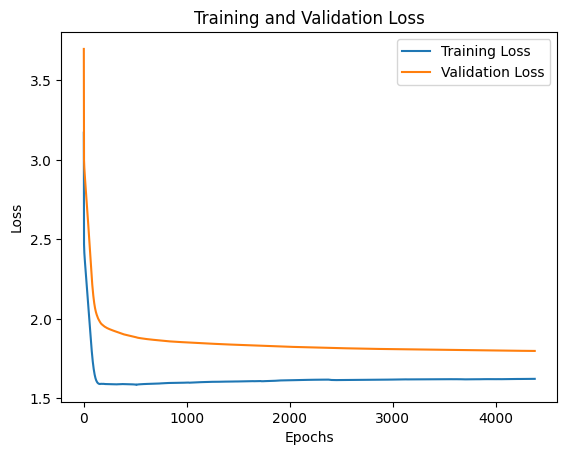

In [10]:
model=MLP(n_hidden_units=200,
          batch_size=200,
          n_epochs=5000,
          learning_rate=0.001,
          momentum=0.9,
          weight_decay=0.0001,
          loss='mse')
model.fit(X_train, y_train, validation_data=(X_val, y_val), early_stopping=6)

# Inference

In [11]:
pred = model.predict(X_val)
RMSE = np.sqrt(mean_squared_error(y_val, pred))
print(f'Root Mean Squared Error of validation data\n{RMSE}')

Root Mean Squared Error of validation data
1.8962636041624434


# Submission

In [13]:
test_preds = model.predict(prep.test)
submission_df = pd.DataFrame({'id':prep.ids, 'Rings':test_preds})
submission_df.to_csv('submission.csv', index=False)
submission_df

,id,Rings
0,90615,9.553991
1,90616,9.725560
2,90617,10.210990
3,90618,10.123431
4,90619,7.538826
...,...,...
60406,151021,6.401706
60407,151022,9.520059
60408,151023,12.207843
60409,151024,13.211614
